# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [154]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from plotting_functions import plot_roc_curves, plot_classification_report, plot_confusion_matrices
from utils import build_resampled_datasets, best_f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 Φόρτωση των δεδομένων
Φορτώνουμε τα δεδομένα από το αρχείο `movies.xlsx` σε ένα pandas dataframe.

In [155]:
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

In [156]:
df = pd.read_excel('movies.xlsx')
last_idx = len(df) - 1

df_un_orig = pd.read_excel('movies_test_anon.xlsx')
# df_unkwn = pd.read_excel('movies_test_anon_sample.xlsx')

# Concat two dataframes
df = pd.concat([df, df_un_orig.drop(['ID'], axis=1)])

Μετονομάζουμε τις στήλες σε πιο χρήσιμα ονόματα αφαιρώντας τα επιπλέον κενά. 

In [157]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df_unkwn_unkwn_unkwn_unkwn columns
df = df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων
Βλέπουμε το περιεχόμενο του dataframe εμφανίζοντας τις πρώτες 5 γραμμές.

In [158]:
# split
df_un = df.iloc[last_idx+1:]
df = df.iloc[:last_idx+1]

Τα βασικά χαρακτηριστικά του dataframe όπως τον αριθμό των γραμμών και τον τύπο των δεδομένων της κάθε στήλης.

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   object 
 

Βασικά στατιστικά των στηλών που περιλαμβάνων αριθμητικούς τύπους δεδομένων όπως τη μέση τιμή και τη κανονική κατανομή.  

In [160]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1402.0,2012.140514,3.190291,2007.0,2009.0,2012.0,2015.0,2017.0
rotten_tomatoes_audience,1401.0,62.122769,17.435737,17.0,49.0,62.0,76.0,98.0
imdb_rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_vs_rt_disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Κάποιες επιπλέον ιδιότητες του dataframe συμπεριλαμβανομένου και του τύπου δεδομένων `object`

In [161]:
df.describe(include='object').T

,count,unique,top,freq
film,1402,1396,Big Miracle,2
script_type,1402,17,original screenplay,546
rotten_tomatoes_critics,1401,102,93,29
metacritic_critics,1402,90,51,39
average_critics,1402,196,64,25
metacritic_audience,1402,78,66,50
rotten_tomatoes_vs_metacritic_deviance,1402,82,-1,58
average_audience,1402,116,58,45
audience_vs_critics_deviance,1402,78,-5,54
...,...,...,...,...


# 2. Καθάρισμα δεδομένων
Ελέγχουμε και αντιμετωπίζουμε **missing values**, **outliers** και **διπλότυπα**.


## 2.1 Έλεγχος για διπλότυπα

Ελέγχουμε για διπλότυπα με το όνομα της ταινίας.

In [162]:
df[df.duplicated(subset=['film'], keep=False)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.0,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.0,36931089,37.0,20.79,20788004,57719093,58.0,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.0,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.0,20157300,20.0,4.56,4561915,24719215,25.0,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.0,20275446,20.0,10.81,10808153,31083599,31.0,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.0,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.0,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.0,16377274,16.0,11.88,11880786,28258060,28.0,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.0,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.9,41.80,41800000,102700477,103.0,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

## 2.2 Απών τιμές
Ελέγχουμε για τυχών απών τιμές όπως `NaN` και `-`.

In [163]:
#Concat
df = pd.concat([df, df_un])

Μετατροπή άκυρων τιμών σε NaN

In [164]:
# replace white characters with NaN
df = df.replace(r'^-$', np.nan, regex=True)
#Count NaN values per column
df.isna().sum()

film                                         0
year                                         0
script_type                                193
rotten_tomatoes_critics                      6
metacritic_critics                          18
average_critics                             12
rotten_tomatoes_audience                     1
metacritic_audience                         19
rotten_tomatoes_vs_metacritic_deviance      19
average_audience                            11
audience_vs_critics_deviance                16
primary_genre                             1689
                                          ... 
worldwide_gross                             23
worldwide_gross_($million)                  22
of_gross_earned_abroad                     132
budget_($million)                           74
budget_recovered                            92
budget_recovered_opening_weekend            88
distributor                               1562
imdb_rating                               1405
imdb_vs_rt_di

Μετατροπή σε αριθμητικά

In [165]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('#VALUE!','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)

Υπολογισμός NaN τιμών από άλλες τιμές όπου είναι εφικτό

In [166]:
df['metacritic_critics'] = df.apply(lambda row: row['average_critics'] * 2 - row['rotten_tomatoes_critics'] if pd.isnull(row['metacritic_critics']) and pd.notnull(row['average_critics']) else row['metacritic_critics'], axis=1)
df['average_critics'] = df.apply(lambda row: (row['rotten_tomatoes_critics'] + row['metacritic_critics']) / 2 if pd.isnull(row['average_critics']) else row['average_critics'], axis=1)
df['metacritic_audience'] = df.apply(lambda row: row['average_audience'] * 2 - row['rotten_tomatoes_audience'] if pd.isnull(row['metacritic_audience']) and pd.notnull(row['average_audience']) else row['metacritic_audience'], axis=1)
df['rotten_tomatoes_vs_metacritic_deviance'] = df.apply(lambda row: row['rotten_tomatoes_audience'] - row['metacritic_audience'] if pd.isnull(row['rotten_tomatoes_vs_metacritic_deviance']) and pd.notnull(row['rotten_tomatoes_audience']) and pd.notnull(row['metacritic_audience']) else row['rotten_tomatoes_vs_metacritic_deviance'], axis=1)
df['foreign_gross'] = df.apply(lambda row: row['worldwide_gross'] - row['domestic_gross'] if pd.isnull(row['foreign_gross']) and pd.notnull(['worldwide_gross']) and pd.notnull(['domestic_gross']) else row['foreign_gross'], axis=1)
df['foreign_gross_($million)'] = df.apply(lambda row: row['foreign_gross'] / 1000 if pd.isnull(row['foreign_gross_($million)']) and pd.notnull(row['foreign_gross']) else row['foreign_gross_($million)'], axis=1)
df['of_gross_earned_abroad'] = df.apply(lambda row: row['foreign_gross'] / row['worldwide_gross'] if pd.isnull(row['of_gross_earned_abroad']) and pd.notnull(row['foreign_gross']) and pd.notnull(row['worldwide_gross']) else row['foreign_gross_($million)'], axis=1)
df['budget_recovered'] = df.apply(lambda row: row['worldwide_gross_($million)'] / row['budget_($million)'] * 100 if pd.isnull(row['budget_recovered']) and pd.notnull(row['worldwide_gross_($million)']) and pd.notnull(row['budget_($million)']) else row['budget_recovered'], axis=1)
df['budget_recovered_opening_weekend'] = df.apply(lambda row: row['opening_weekend'] / row['worldwide_gross'] * 100 if pd.isnull(row['budget_recovered_opening_weekend']) and pd.notnull(row['opening_weekend']) and pd.notnull(row['worldwide_gross']) else row['budget_recovered_opening_weekend'], axis=1)

Αντικατάσταση κατηγορηματικών τιμών

In [167]:
df['script_type'] = df['script_type'].fillna(df['script_type'].describe()['top'])
df['primary_genre'] = df['primary_genre'].fillna(df['primary_genre'].describe()['top'])
df['genre'] = df['genre'].fillna(df['genre'].describe()['top'])

Αντικατάσταση εναπομείναντων NaN τιμών με το μέσο όρο της στήλης όπου δεν είναι δυνατόν να υπολογιστεί.

In [168]:
df.loc[:, 'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'] = df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].fillna(df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].mean())
df.loc[:, 'opening_weekend' : 'budget_recovered_opening_weekend'] = df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].fillna(df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].mean())

## 2.3 Έλεγχος για outliers
Ελέγχουμε και διορθώνουμε τυχών outliers με πρώτο βήμα να μετατρέψουμε τις συμβολοσειρές σε κανονικές αριθμητικές μεταβλητές float ή integer. Επίσης μετατρέπουμε την στήλη `oscar_winners` σε 0 ή 1.

In [169]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                   0.0
metacritic_critics                        0.0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                       0.0
rotten_tomatoes_vs_metacritic_deviance    0.0
average_audience                          0.0
audience_vs_critics_deviance              0.0
primary_genre                               0
                                         ... 
worldwide_gross                           0.0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                                 0
imdb_rating                               0.0
imdb_vs_rt_disparity              

Τελευταία διόρθωση συγκεκριμένων εσφαλμένων τιμών

In [170]:
df['budget_($million)'] = df.apply(lambda row: row['budget_($million)'] / 1000 if row['budget_($million)'] > 999 else row['budget_($million)'], axis=1)

# Convert 'of_gross_earned_abroad to 0-1 range
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

Μία στατιστική εικόνα του dataframe με διορθωμένες αριθμητικές τιμές.

In [171]:
# df = df.reset_index()
# df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
year,1967.00,2014.31,4.42,2007.00,2010.00,2015.00,2018.00,2022.00
rotten_tomatoes_critics,1967.00,55.79,27.22,0.00,32.00,57.00,81.00,100.00
metacritic_critics,1967.00,54.53,17.19,0.00,42.00,54.00,66.00,100.00
average_critics,1967.00,55.37,21.80,0.00,37.00,56.00,74.00,99.00
rotten_tomatoes_audience,1967.00,65.10,18.53,8.00,51.00,66.00,80.00,100.00
metacritic_audience,1967.00,62.32,13.75,2.00,54.00,64.00,72.00,100.00
rotten_tomatoes_vs_metacritic_deviance,1967.00,2.83,14.96,-60.00,-7.00,2.00,11.00,84.00
average_audience,1967.00,63.90,14.58,5.00,54.00,65.00,75.00,100.00
audience_vs_critics_deviance,1967.00,-8.59,14.89,-68.00,-19.00,-8.00,2.00,47.00
...,...,...,...,...,...,...,...,...


# 3. Εξερεύνηση χαρακτηριστικών
Εξερευνούμε τα χαρακτηριστικά των δεδομένων εκτελώντας αλγόριθμούς υπολογισμού συσχετίσεων και PCA

## 3.1 Προεπεξεργασία των δεδομένων

Μετατροπή των στηλών `script_typr` και `genre` σε 1 hot encoding

In [172]:
# Make a copy of dataframe
df_cl = df

In [173]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [174]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')
genre_types.remove('blac')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

In [175]:
# Convert Oscar Winners to 1 hot encoding
df_cl['oscar_winners'] = df_cl["oscar_winners"].notnull().astype("int")

Μία γενική εικόνα του dataframe μετά τους μετασχηματισμούς

In [176]:
df_cl.head().T

,0,1,2,3,4
gen_fantasy,0,0,0,0,0
gen_drama,0,0,0,0,0
gen_sports,0,0,0,0,0
gen_thriller,0,0,0,0,0
gen_history,0,0,0,0,0
gen_biography,0,0,0,0,0
gen_horror,0,0,0,0,0
gen_crime,0,0,0,0,0
gen_family,0,0,0,0,0
...,...,...,...,...,...


## 3.2 Ανάλυση συσχετίσεων

### 3.2.1 Συσχέτιση χαρακτηριστικών με τη στήλη `oscar_winners`
Υπολογίζουμε την συσχέτιση με τη στήλη `oscar_winners` για να διαπιστώσουμε ποιο χαρακτηριστικό συμβάλει περισσότερο στο αν έχει πάρει oscar μία ταινία. Χωρίς έκπληξη διαπιστώνουμε ότι οι κριτικές έχουν τη μεγαλύτερη βαρύτητα όμως γενικά οί συσχετίσεις είναι μικρές.

In [177]:
# # split
df_un_cl = df_cl.iloc[last_idx+1:]
df_cl = df_cl.iloc[:last_idx+1]
df_cl = df_cl.reset_index().drop(['index'], axis=1)

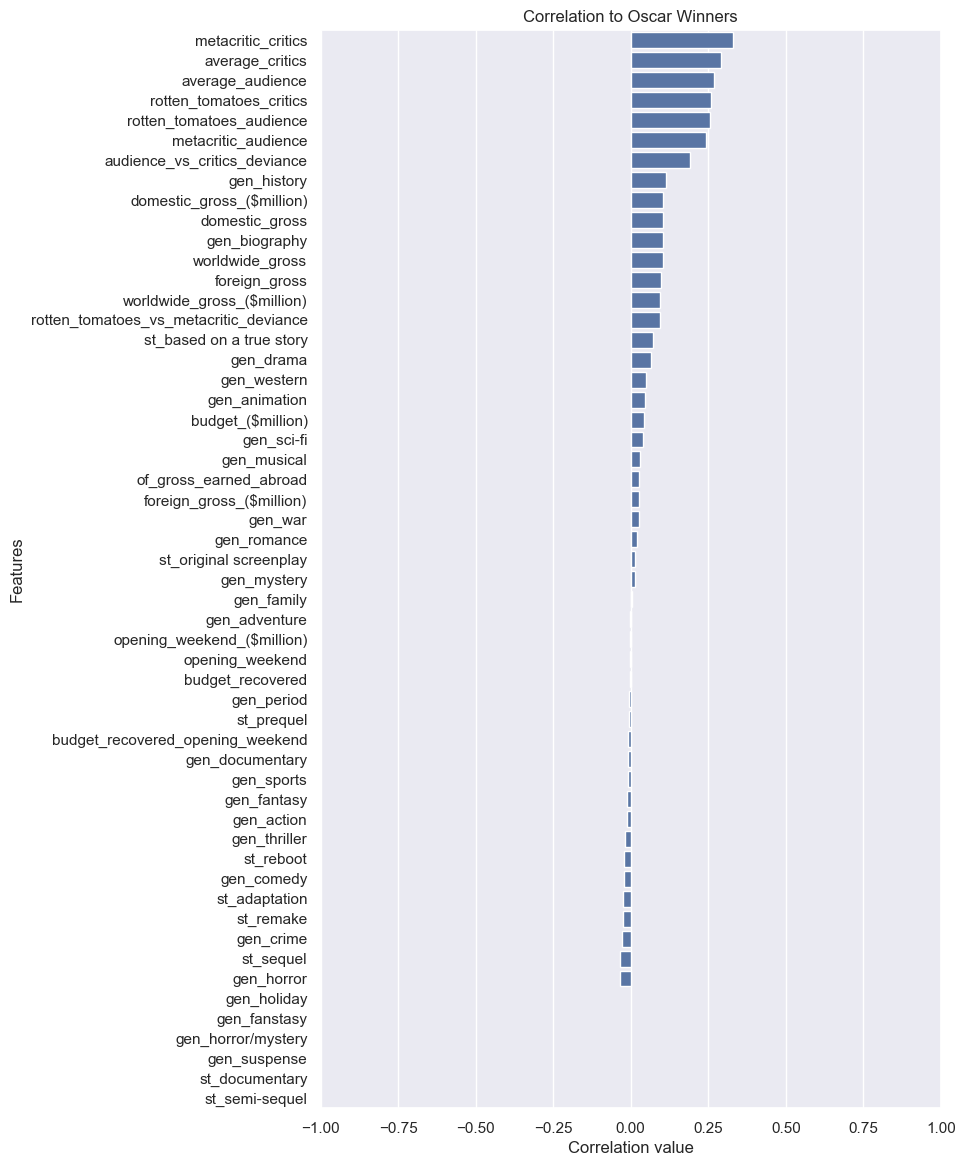

In [178]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)
plt.show()

### 3.2.2 Υπολογισμός Variance Inflation Factor
Υπολογίζουμε το Variance Inflation Factor των χαρακτηριστικών για να διαπιστώσουμε αν υπάρχει φαινόμενο multicollinearity. Σύμφωνα με το αποτέλεσμα υπάρχει τεράστιο φαινόμενο multicollinearity καθώς κάποιες τιμές είναι πολύ μεγάλες.


In [179]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/bidaze/Documents/CLASSES/Data Mining/HUA-DIT-Data-mining-project/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/bidaze/Documents/CLASSES/Data Mining/HUA-DIT-Data-mining-project/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
50,of_gross_earned_abroad,inf
46,foreign_gross_($million),inf
45,domestic_gross_($million),3195436.80
44,domestic_gross,3194174.49
42,opening_weekend,523193.41
43,opening_weekend_($million),523183.52
38,metacritic_audience,13537.84
34,rotten_tomatoes_critics,13354.20
37,rotten_tomatoes_audience,12599.41
...,...,...


### 3.2.3 Πίνακας συσχέτισης
Υπολογίζουμε τον πίνακα συσχέτισης μεταξύ όλων των χαρακτηριστικών.

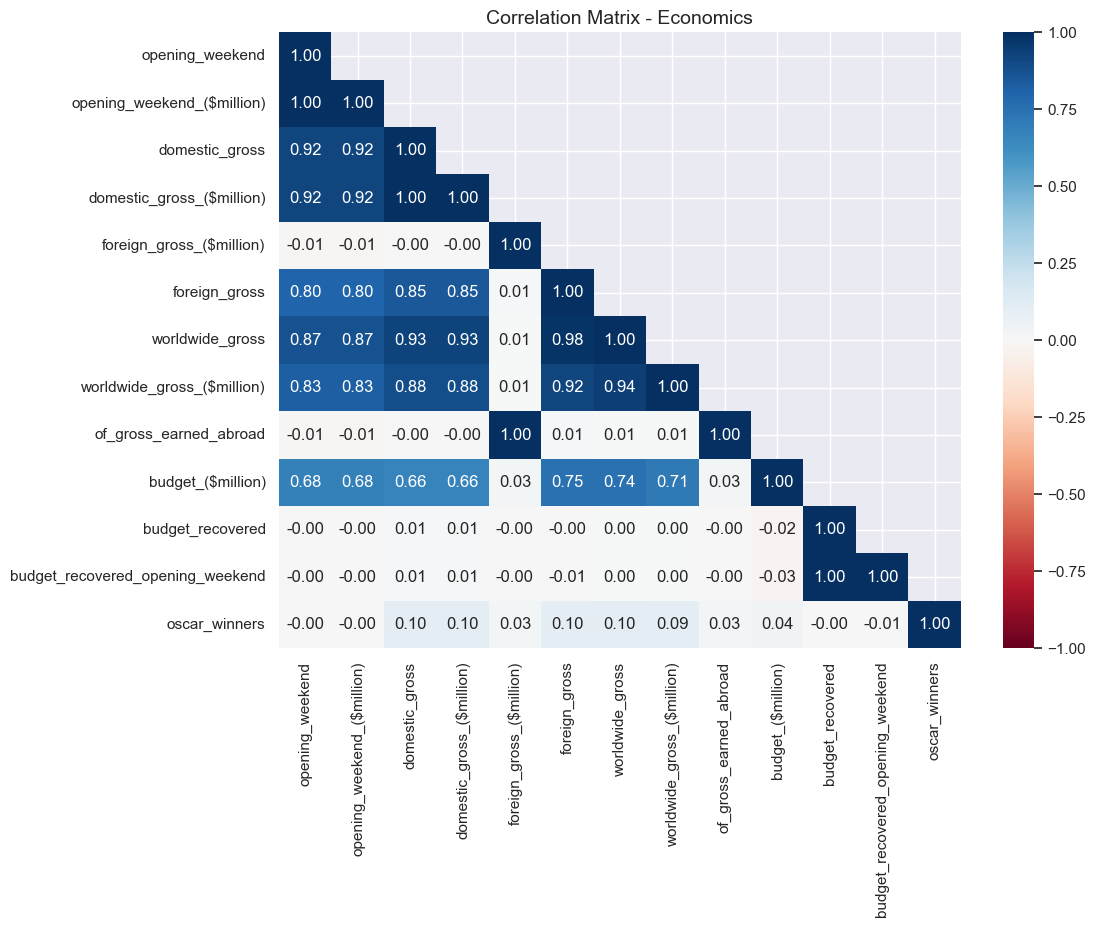

In [180]:
# Economics
corr_mat = df_cl_corr[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(11, 8))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Economics', fontsize=14)
plt.show()

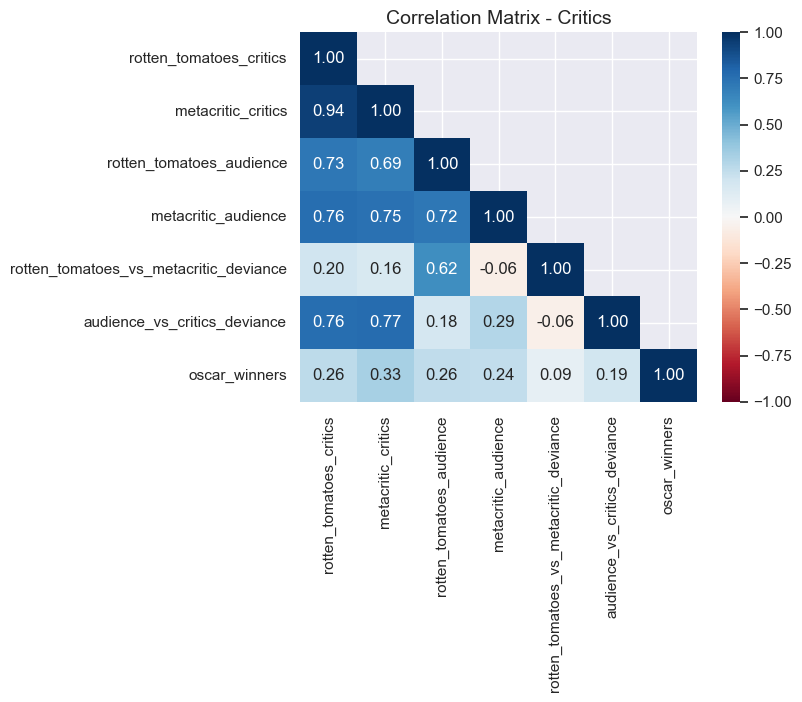

In [181]:
# Economics
corr_mat = df_cl_corr[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance',
       'audience_vs_critics_deviance','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
# plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Critics', fontsize=14)
plt.show()

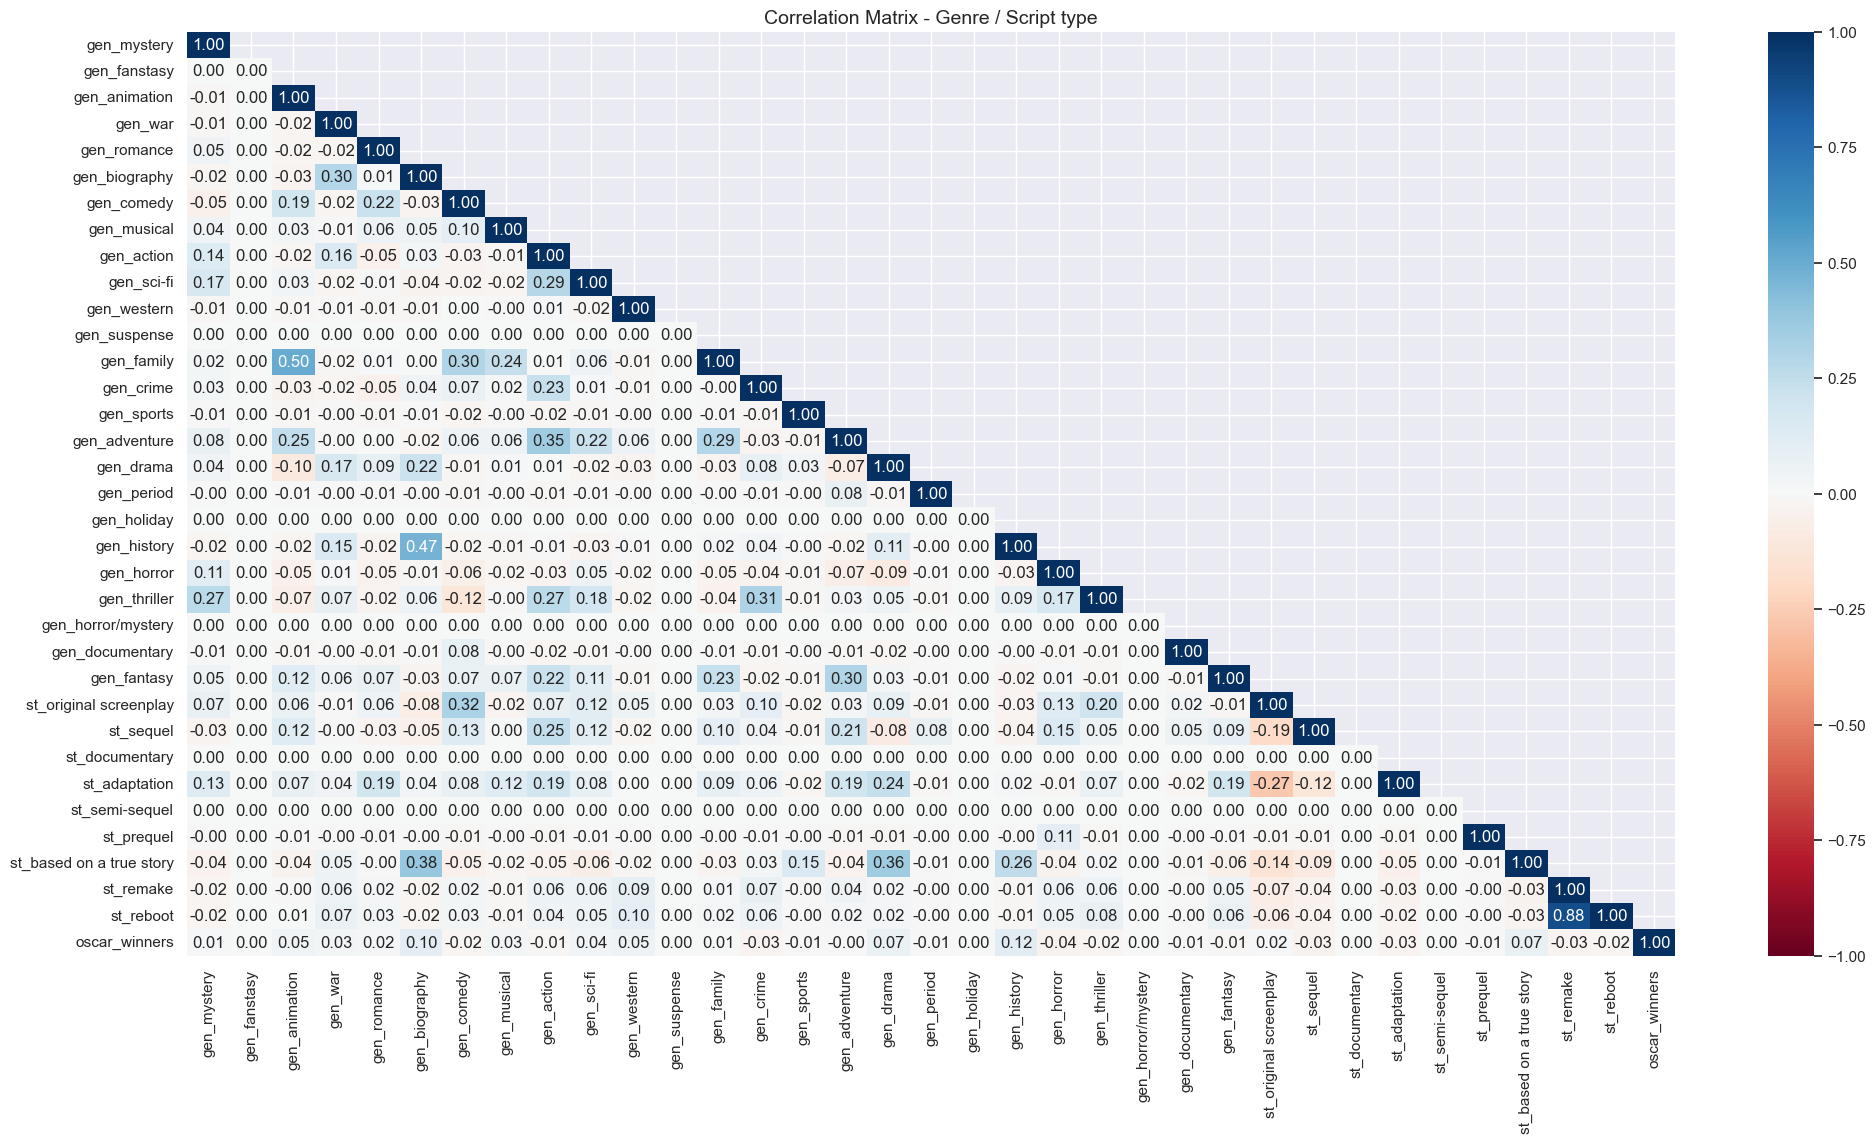

In [182]:
# Economics
corr_mat = df_cl_corr[['gen_mystery', 'gen_fanstasy', 'gen_animation', 'gen_war',
       'gen_romance', 'gen_biography', 'gen_comedy', 'gen_musical',
       'gen_action', 'gen_sci-fi', 'gen_western', 'gen_suspense', 'gen_family',
       'gen_crime', 'gen_sports', 'gen_adventure', 'gen_drama', 'gen_period',
       'gen_holiday', 'gen_history', 'gen_horror', 'gen_thriller',
       'gen_horror/mystery', 'gen_documentary', 'gen_fantasy',
       'st_original screenplay', 'st_sequel', 'st_documentary',
       'st_adaptation', 'st_semi-sequel', 'st_prequel',
       'st_based on a true story', 'st_remake', 'st_reboot','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(24, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Genre / Script type', fontsize=14)
plt.show()

In [183]:
# Plot correlation matrix
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)

# mask = np.zeros_like(corr_mat)
# mask[np.triu_indices_from(mask, k=1)] = True

# sns.set_theme()
# plt.figure(figsize=(30, 12))
# sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Matrix', fontsize=14)
# plt.show()

In [184]:
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)
# corr_mat = corr_mat.iloc[-1]
# corr_mat = corr_mat[corr_mat.values >= 0.05]
# df_cl_sel = df_cl[corr_mat.index]

### 3.2.4 Pairplot μεταξύ κάποιων σημαντικών χαρακτηριστικών.

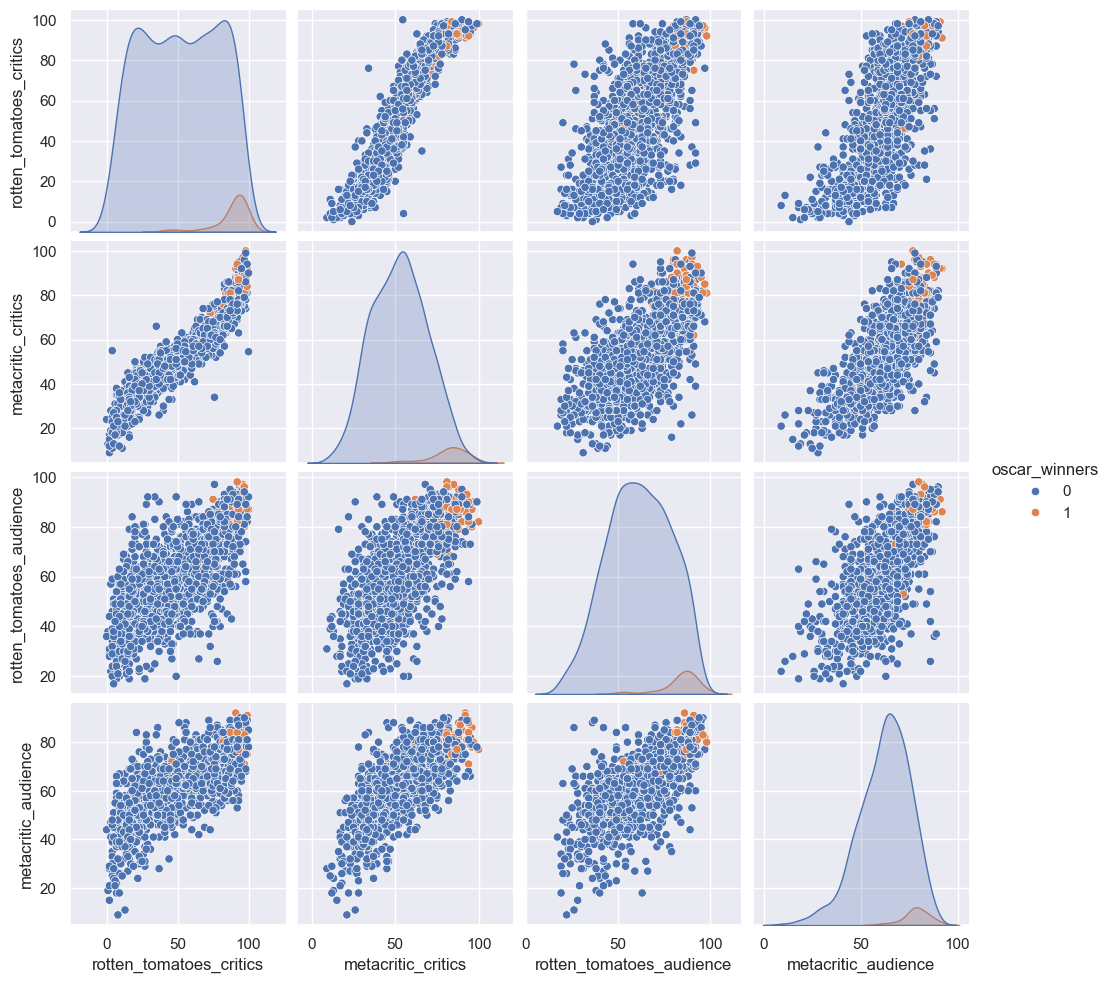

In [185]:
y = df_cl[['oscar_winners']]
# meta = df_cl['film'] 
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')
plt.show()

## 3.3 Principle Components Analysis
Εκτελούμε τον αλγόριθμο PCA για να δούμε αν τα δεδομένα μπορούν να αναπαρασταθούν σε λιγότερες διαστάσεις.

Επιλέγουμε τα πιο σημαντικά χαρακτηριστικά και υπολογίζουμε τις πιο σημαντικές διαστάσεις των Principal Components.

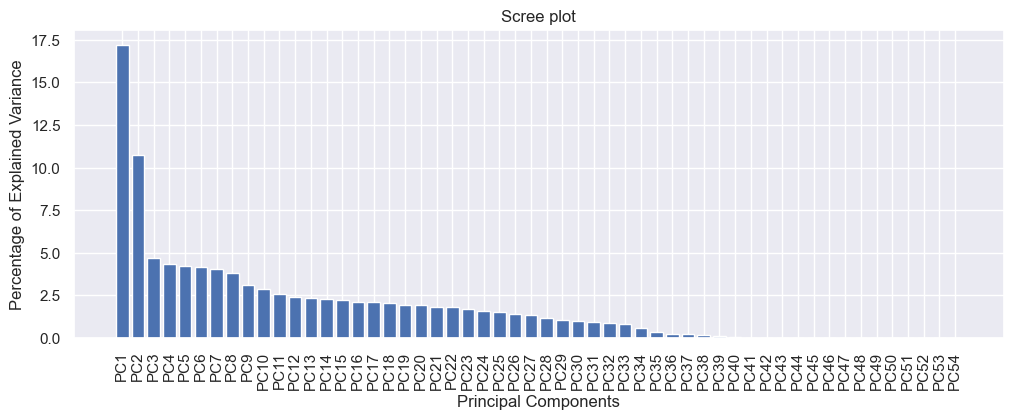

In [186]:
x = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

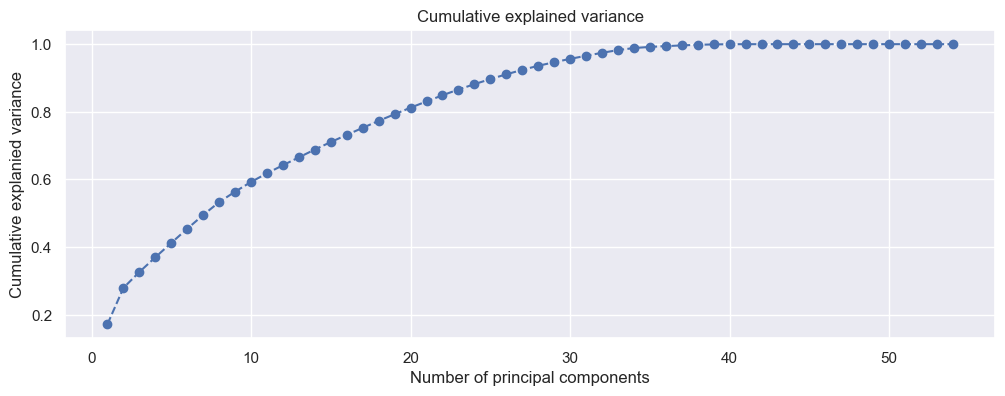

In [187]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

Μπορούμε να διακρίνουμε μία μικρή συσταδοποίηση των oscar winners κάνοντας plot τα πρώτα 2 principal components αλλά λόγω της πυκνότητας δεν έχουμε τα καλά αποτελέσματα.

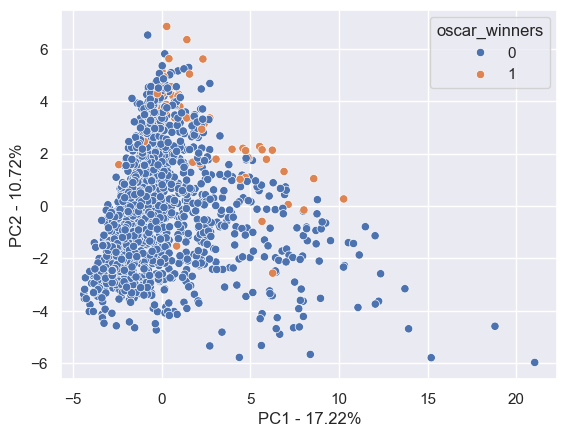

In [188]:
sns.set_theme()
# plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')
plt.show()

Επαναϋπολογίζουμε τα principal components και αυτή τη φορά κρατάμε τα n πρώτα πιο σημαντικά.

In [189]:
# # Calculate PCA
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(x)

# # Concat PCA results to dataframe
# principal_components_df = pd.DataFrame(principal_components)
# principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
# df_cl = pd.concat([df_cl, principal_components_df], axis=1)

# 4. Συσταδοποίηση

## 4.1 KMeans
Χωρήσαμε τα χαρακτηριστικά σε δύο ομάδες. Τα οικονιμά χαρακτηριστικά και οι βαθμολογίες κριτών/κοινού. Στη συνέχεια εκτελέσαμε PCA στις δύο αυτές ομάδες και κάναμε plot τα PC1 και PC2.

### 4.1.1 KMeans - PCA - Economy features

In [190]:
x = df_cl[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']]

# x = df_cl[['opening_weekend_($million)',
#        'domestic_gross_($million)', 'foreign_gross_($million)',
#        'worldwide_gross_($million)',
#        'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
#        'budget_recovered_opening_weekend']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_economic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

Εύρεση αριθμό συστάδων με την μέθοδο elbow

In [191]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

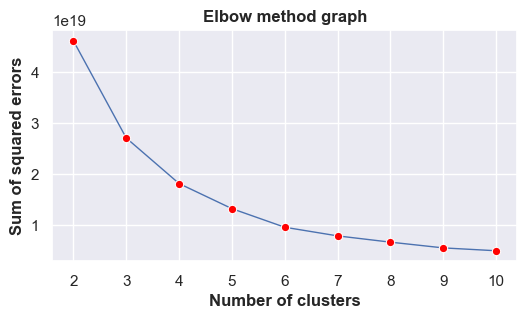

In [192]:
x = df_cl[['PC1_economic', 'PC2_economic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

Εκτελούμε την μεθοδο KMeans συσταδοποίηση με τον αριθμό των συστάδων που βρήκαμε παραπάνω.

In [193]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, n_init='auto')
kmeans_pca.fit(df_cl[['PC1_economic', 'PC2_economic']])

#Append clusters to dataframe
df_cl['kmeans_pca_economic'] = kmeans_pca.labels_

In [194]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_economic']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 236, 0: 1088, 1: 78} | oscars: {2: 18, 0: 32, 1: 6}


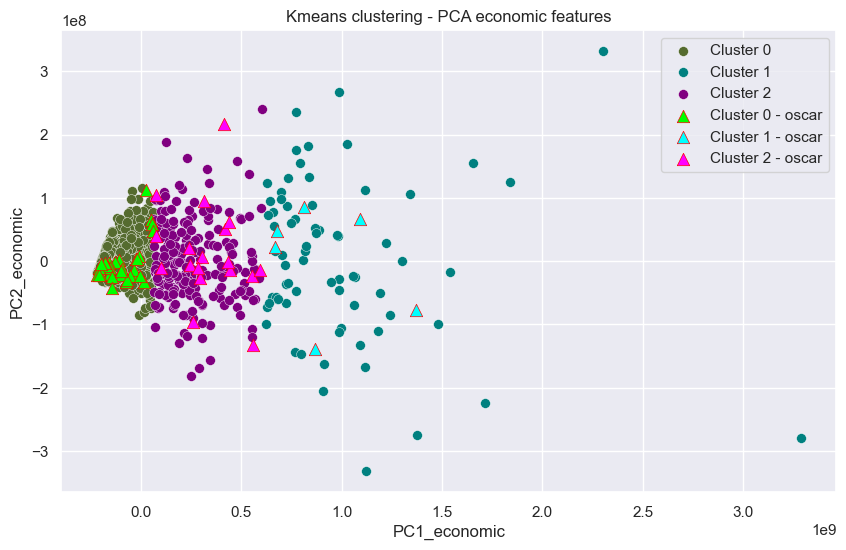

In [195]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_economic', xfeature='PC1_economic', yfeature='PC2_economic', title='Kmeans clustering - PCA economic features')

### 4.1.2 KMeans - PCA Critics

In [196]:
x = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance', 'average_audience',
       'audience_vs_critics_deviance']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_critic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

In [197]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

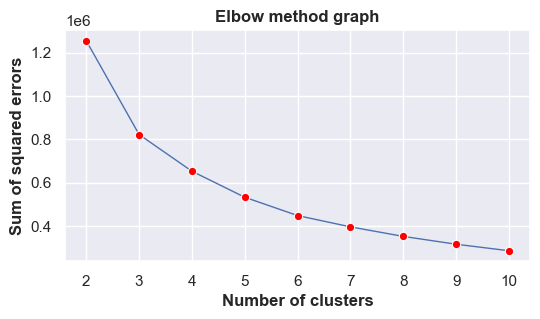

In [198]:
x = df_cl[['PC1_critic', 'PC2_critic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

In [199]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans_pca.fit(df_cl[['PC1_critic', 'PC2_critic']])

#Append clusters to dataframe
df_cl['kmeans_pca_critics'] = kmeans_pca.labels_

In [200]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_critics']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 521, 0: 407, 1: 474} | oscars: {2: 5, 0: 51, 1: 0}


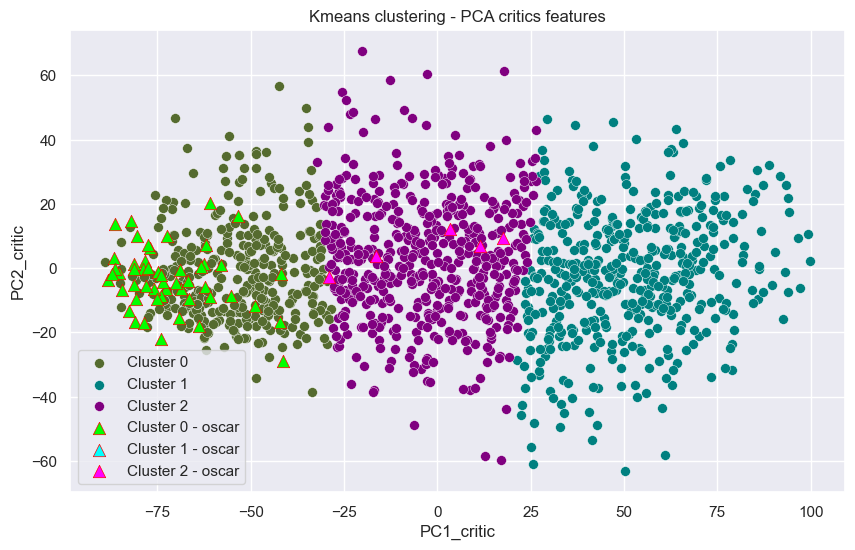

In [201]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_critics', xfeature='PC1_critic', yfeature='PC2_critic', title='Kmeans clustering - PCA critics features')

### 4.1.3 Συμπεράσματα kmeans - στατιστικά

#### Συστάδα 0 

Βαθμολογίες κριτικών / κοινού

In [202]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T


,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,407.0,86.282555,7.401322,66.00000,81.0,87.0,92.0,100.0
metacritic_critics,407.0,74.323169,9.139530,54.00000,67.0,73.0,81.0,100.0
average_critics,407.0,80.465290,7.818347,55.37289,75.0,80.0,86.0,99.0
rotten_tomatoes_audience,407.0,80.093366,9.589923,43.00000,74.0,82.0,87.0,98.0
metacritic_audience,407.0,75.248157,7.022121,53.00000,71.0,76.0,80.0,92.0
rotten_tomatoes_vs_metacritic_deviance,407.0,5.213759,9.310517,-19.00000,0.0,5.0,10.0,84.0
average_audience,407.0,77.687961,8.231244,7.00000,73.0,79.0,84.0,93.0
audience_vs_critics_deviance,407.0,2.644737,9.087154,-18.00000,-4.0,2.0,8.0,33.0
oscar_winners,407.0,0.125307,0.331474,0.00000,0.0,0.0,0.0,1.0


Οικονομικά στοιχεία

In [203]:
df_cl[(df_cl['kmeans_pca_economic'] == 0)][['opening_weekend_($million)',  
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),1088.0,12.704494,10.087350,0.00,5.0000,10.94000,18.230000,60.20
domestic_gross_($million),1088.0,40.841434,31.151033,0.00,16.9175,33.45500,56.322500,169.71
foreign_gross_($million),1088.0,974.548456,16280.306851,0.00,6.9400,25.51500,57.367500,489121.00
worldwide_gross_($million),1088.0,78.534522,60.469147,0.00,30.5425,62.84500,114.962500,240.00
of_gross_earned_abroad,1088.0,9.745485,162.803069,0.00,0.0694,0.25515,0.573675,4891.21
budget_($million),1088.0,35.571568,30.358788,0.10,15.0000,28.00000,45.000000,200.00
budget_recovered,1088.0,1596.324193,39091.337575,5.00,124.5900,225.81000,372.022500,1289066.67
budget_recovered_opening_weekend,1088.0,197.232562,3973.544799,0.05,17.5375,34.03500,62.252500,130666.67


Είδη ταινίας

In [204]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/1104439937.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_drama             106.0
gen_comedy             66.0
gen_action             57.0
gen_adventure          56.0
gen_thriller           50.0
gen_sci-fi             33.0
gen_animation          25.0
gen_crime              24.0
gen_romance            21.0
gen_fantasy            19.0
gen_biography          19.0
gen_horror             15.0
                      ...  
gen_history            11.0
gen_mystery             9.0
gen_musical             4.0
gen_war                 4.0
gen_sports              2.0
gen_western             2.0
gen_fanstasy            NaN
gen_holiday             NaN
gen_documentary         NaN
gen_period              NaN
gen_suspense            NaN
gen_horror/mystery      NaN
Name: 1, Length: 25, dtype: float64

#### Συστάδα 1

Βαθμολογίες κριτικών / κοινού

In [205]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,474.0,21.620253,9.996156,0.0,14.0,21.0,29.00,46.0
metacritic_critics,474.0,35.073840,8.118105,9.0,30.0,36.0,41.00,55.0
average_critics,474.0,28.564346,8.376359,6.0,23.0,29.0,35.00,47.0
rotten_tomatoes_audience,474.0,47.725738,13.324566,17.0,39.0,48.0,56.00,90.0
metacritic_audience,474.0,50.421941,11.714324,9.0,44.0,51.0,58.00,84.0
rotten_tomatoes_vs_metacritic_deviance,474.0,-2.696203,13.958581,-44.0,-12.0,-4.0,4.75,45.0
average_audience,474.0,49.305907,10.442447,15.5,43.0,50.0,56.00,78.0
audience_vs_critics_deviance,474.0,-20.970464,10.056246,-48.0,-28.0,-22.0,-15.00,12.0
oscar_winners,474.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


Οικονομικά στοιχεία

In [206]:
df_cl[(df_cl['kmeans_pca_economic'] == 1)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T


,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),78.0,105.667179,45.805041,0.00000,71.207500,98.3200,134.7150,247.9700
domestic_gross_($million),78.0,329.271282,133.697244,45.44000,244.837500,313.2600,367.8075,936.6600
foreign_gross_($million),78.0,599.529885,194.456639,2.02100,474.312500,538.3500,700.0000,1162.0400
worldwide_gross_($million),78.0,850.648833,414.985905,1.01700,716.267500,827.3250,965.1400,2781.5000
of_gross_earned_abroad,78.0,5.995299,1.944566,0.02021,4.743125,5.3835,7.0000,11.6204
budget_($million),78.0,172.974359,55.876946,35.00000,149.250000,175.0000,200.0000,300.0000
budget_recovered,78.0,629.444872,328.939086,320.33000,420.672500,505.7250,691.1175,1987.6400
budget_recovered_opening_weekend,78.0,71.798077,55.010837,0.16000,41.242500,55.6350,83.6000,352.5800


Είδη ταινίας

In [207]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/3334173668.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            98.0
gen_action            77.0
gen_thriller          50.0
gen_drama             43.0
gen_adventure         43.0
gen_horror            40.0
gen_romance           27.0
gen_sci-fi            22.0
gen_fantasy           22.0
gen_crime             16.0
gen_animation         11.0
gen_family             9.0
                      ... 
gen_war                3.0
gen_western            2.0
gen_history            1.0
gen_musical            1.0
gen_biography          1.0
gen_period             1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_documentary        NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

#### Συστάδα 3

Βαθμολογίες κριτικών / κοινού

In [208]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,521.0,56.285182,11.475284,26.0,47.0,56.0,66.0,83.0
metacritic_critics,521.0,54.583607,6.417541,33.0,50.0,55.0,59.0,76.0
average_critics,521.0,55.666499,8.259446,37.0,49.0,55.0,62.0,76.0
rotten_tomatoes_audience,521.0,61.188295,11.942036,20.0,54.0,62.0,70.0,92.0
metacritic_audience,521.0,64.577061,7.801889,42.0,60.0,65.0,70.0,89.0
rotten_tomatoes_vs_metacritic_deviance,521.0,-3.507385,11.989239,-60.0,-10.0,-3.0,3.0,34.0
average_audience,521.0,63.113808,8.183310,38.0,58.0,63.0,69.0,83.0
audience_vs_critics_deviance,521.0,-7.584983,11.212743,-42.0,-15.0,-8.0,-1.0,30.0
oscar_winners,521.0,0.009597,0.097586,0.0,0.0,0.0,0.0,1.0


Οικονομικά στοιχεία

In [209]:
df_cl[(df_cl['kmeans_pca_economic'] == 2)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),236.0,44.332076,22.015183,0.940000,29.637500,40.4550,55.110000,152.54
domestic_gross_($million),236.0,142.841992,60.871806,5.020000,102.017500,138.4650,177.805000,408.01
foreign_gross_($million),236.0,1496.477034,19278.616142,53.240000,173.197500,222.3900,301.807500,296402.00
worldwide_gross_($million),236.0,384.582500,118.382895,217.440000,288.012500,358.5600,468.250000,691.00
of_gross_earned_abroad,236.0,14.964770,192.786161,0.532400,1.731975,2.2239,3.018075,2964.02
budget_($million),236.0,114.806417,55.316509,4.500000,75.000000,110.0000,150.000000,300.00
budget_recovered,236.0,506.395535,600.304266,109.000000,248.045000,334.5200,490.377500,5651.77
budget_recovered_opening_weekend,236.0,57.681909,79.995645,0.510495,26.242500,36.8650,53.855000,741.71


Είδη ταινίας

In [210]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/2827174932.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            99.0
gen_drama             84.0
gen_action            74.0
gen_thriller          65.0
gen_adventure         55.0
gen_sci-fi            31.0
gen_horror            29.0
gen_crime             29.0
gen_fantasy           25.0
gen_animation         25.0
gen_romance           24.0
gen_family            22.0
                      ... 
gen_biography          7.0
gen_history            4.0
gen_musical            4.0
gen_war                3.0
gen_documentary        2.0
gen_western            1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_period             NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

## 4.2 Agglomerative

Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

In [211]:
# Create dataframe with chosen features
df_agg = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)

In [212]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

# Create dictionary with clusters
agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

# Print clustering results
print(agg_dict)
print(agg_oscars)

{1: 146, 0: 1256}
{1: 15, 0: 41}


Επιλογή χαρακτηριστικών με βάση τον πίνακα συσχέτησης

In [213]:
# Create dataframe with chosen features
df_agg = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]

Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

In [214]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

# Create dictionary with clusters
agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

# Print clustering results
print(agg_dict)
print(agg_oscars)

{0: 839, 1: 563}
{0: 3, 1: 53}


Εφαρμόζουμε PCA στα χαρακτηριστικά που επιλέξαμε προηγουμένως.

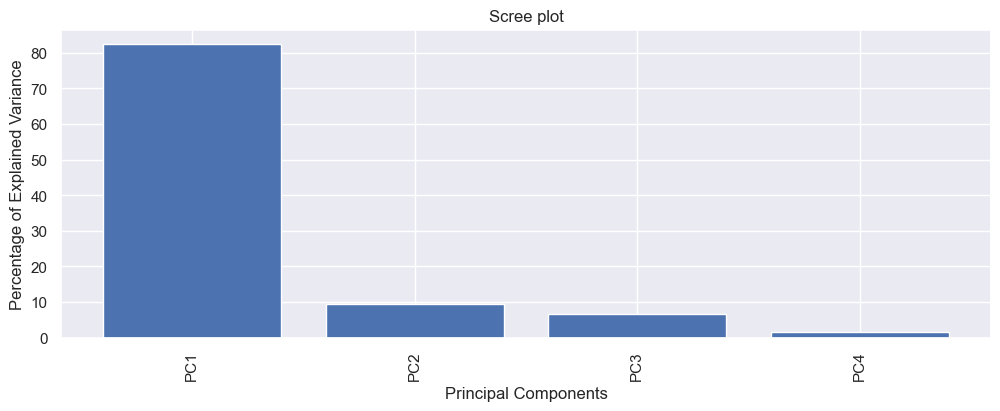

In [215]:
x = df_agg
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Perform PCA
principal_components = pca.fit_transform(x)

# Create dataframe with results of PCA
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]
principal_df = pd.DataFrame(data = principal_components, columns = labels)

# Add labels in previous dataframe
final_agg_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

# Plot Percentage of Explained Variance for principal components
sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative με τα δύο πρώτα principal components από τα επιλεγμένα χαρακτηριστικά.

In [216]:
# Calculate agglomerative clustering with first two principal components
final_agg_df = final_agg_df.drop(['PC3', 'PC4'], axis=1)
x = final_agg_df.drop(['oscar_winners'], axis=1)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(x)

# Create dictionary with clusters
agg_dict = dict(Counter(agg.labels_))

# Save clusters and principal components in main dataframe
df_cl['agglomerative'] = agg.labels_
df_cl['PC1_agg'] = x['PC1']
df_cl['PC2_agg'] = x['PC2']

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

# Print clustering results
print(agg_dict)
print(agg_oscars)

{0: 1053, 1: 349}
{0: 5, 1: 51}


In [217]:
# plt.figure(figsize=(10,8))
# sns.scatterplot(x=final_agg_df['PC1'], y=final_agg_df['PC2'], hue=df_cl['agglomerative'], palette='viridis')

# oscar_winners_pca = final_agg_df[final_agg_df['oscar_winners'] == 1]
# plt.scatter(oscar_winners_pca['PC1'], oscar_winners_pca['PC2'], color='red', marker='*', s=25 , label='Oscar Winners')

# plt.title('Agglomerative Clustering with PCA (Oscar Winners Highlighted)')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()
# plt.show()

Scatterplot για το Agglomerative Clustering.

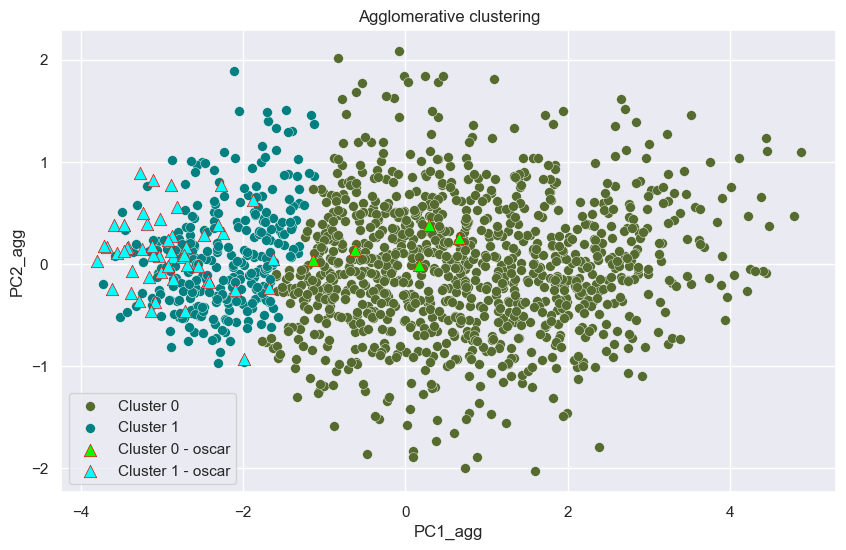

In [218]:
# Plot final agglomerative clustering results
cluster_scatter_plot_2D(df_cl, clusters_column='agglomerative', xfeature='PC1_agg', yfeature='PC2_agg', title='Agglomerative clustering')

### 4.2.2 Συμπεράσματα agglomerative - στατιστικά

Συστάδα 0

In [219]:
df_cl[(df_cl['agglomerative'] == 0)][['rotten_tomatoes_critics', 'metacritic_critics',
                                      'rotten_tomatoes_audience', 'metacritic_audience', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,1053.0,41.822013,21.616119,0.0,23.0,42.0,60.0,93.0
metacritic_critics,1053.0,46.298252,12.589937,9.0,37.0,47.0,56.0,78.0
rotten_tomatoes_audience,1053.0,55.755082,14.670159,17.0,46.0,56.0,66.0,92.0
metacritic_audience,1053.0,58.379534,12.075284,9.0,51.0,60.0,67.0,89.0
oscar_winners,1053.0,0.004748,0.068777,0.0,0.0,0.0,0.0,1.0


In [220]:
df_cl[(df_cl['agglomerative'] == 0)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),1053.0,21.560095,23.478637,0.00,8.0000,14.6100,26.3600,208.81
domestic_gross_($million),1053.0,63.472384,66.817135,0.54,21.8900,42.6600,80.0100,652.05
foreign_gross_($million),1053.0,677.643675,15353.096219,0.00,11.7400,40.0200,106.3700,489121.00
worldwide_gross_($million),1053.0,150.688578,188.757686,1.00,39.8900,84.3700,183.9600,1666.00
of_gross_earned_abroad,1053.0,6.776437,153.530962,0.00,0.1174,0.4002,1.0637,4891.21
budget_($million),1053.0,55.120082,52.399057,0.10,20.0000,35.0000,74.0000,300.00
budget_recovered,1053.0,1654.603563,39735.183796,7.75,142.0000,241.7400,390.8500,1289066.67
budget_recovered_opening_weekend,1053.0,205.770747,4038.822216,0.05,21.5600,38.1200,64.5800,130666.67


In [221]:
df_cl[(df_cl['agglomerative'] == 0)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/1932323384.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            206.0
gen_action            160.0
gen_drama             142.0
gen_thriller          122.0
gen_adventure         111.0
gen_horror             74.0
gen_sci-fi             60.0
gen_romance            55.0
gen_fantasy            51.0
gen_crime              47.0
gen_animation          39.0
gen_family             34.0
                      ...  
gen_biography          10.0
gen_war                 7.0
gen_musical             6.0
gen_history             6.0
gen_western             3.0
gen_documentary         2.0
gen_period              1.0
gen_sports              1.0
gen_fanstasy            NaN
gen_holiday             NaN
gen_suspense            NaN
gen_horror/mystery      NaN
Name: 1, Length: 25, dtype: float64

In [222]:
df_cl[(df_cl['agglomerative'] == 0)][['st_reboot', 'st_adaptation', 'st_documentary', 'st_semi-sequel',
       'st_original screenplay', 'st_based on a true story', 'st_prequel',
       'st_remake', 'st_sequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/1310557282.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_remake', 'st_sequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      241.0
st_adaptation               195.0
st_sequel                   118.0
st_based on a true story     36.0
st_remake                    21.0
st_reboot                    16.0
st_prequel                    1.0
st_documentary                NaN
st_semi-sequel                NaN
Name: 1, dtype: float64

Συστάδα 1

In [223]:
df_cl[(df_cl['agglomerative'] == 1)][['rotten_tomatoes_critics', 'metacritic_critics',
                                      'rotten_tomatoes_audience', 'metacritic_audience', 'oscar_winners']].describe().T

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_critics,349.0,87.825215,6.521480,67.000000,83.0,88.0,93.0,100.0
metacritic_critics,349.0,76.104669,8.447463,54.529652,69.0,75.0,82.0,100.0
rotten_tomatoes_audience,349.0,81.343840,8.901882,54.000000,76.0,83.0,88.0,98.0
metacritic_audience,349.0,76.495702,6.451241,53.000000,73.0,77.0,81.0,92.0
oscar_winners,349.0,0.146132,0.353745,0.000000,0.0,0.0,0.0,1.0


In [224]:
df_cl[(df_cl['agglomerative'] == 1)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

,count,mean,std,min,25%,50%,75%,max
opening_weekend_($million),349.0,28.149341,39.771972,0.00,0.9400,12.0700,37.5100,247.97
domestic_gross_($million),349.0,105.996934,126.043882,0.00,17.9500,59.1000,148.1000,936.66
foreign_gross_($million),349.0,2139.489516,19102.395801,0.00,13.7100,51.3700,207.2200,296402.00
worldwide_gross_($million),349.0,240.351192,326.207941,0.00,32.0000,113.0000,329.3900,2781.50
of_gross_earned_abroad,349.0,21.394895,191.023958,0.00,0.1371,0.5137,2.0722,2964.02
budget_($million),349.0,60.878895,63.454823,0.12,15.0000,32.5000,93.0000,260.00
budget_recovered,349.0,467.361651,512.116667,5.00,194.7100,349.5800,557.1400,5651.77
budget_recovered_opening_weekend,349.0,49.070517,79.781778,0.16,7.9000,30.2900,55.9000,871.43


In [225]:
df_cl[(df_cl['agglomerative'] == 1)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/1488208599.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_drama             91.0
gen_comedy            57.0
gen_action            48.0
gen_adventure         43.0
gen_thriller          43.0
gen_sci-fi            26.0
gen_crime             22.0
gen_animation         22.0
gen_romance           17.0
gen_biography         17.0
gen_fantasy           15.0
gen_history           10.0
                      ... 
gen_family            10.0
gen_mystery            8.0
gen_musical            3.0
gen_war                3.0
gen_western            2.0
gen_sports             1.0
gen_fanstasy           NaN
gen_holiday            NaN
gen_documentary        NaN
gen_period             NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

In [226]:
df_cl[(df_cl['agglomerative'] == 1)][['st_reboot', 'st_adaptation', 'st_documentary', 'st_semi-sequel',
       'st_original screenplay', 'st_based on a true story', 'st_prequel',
       'st_remake', 'st_sequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_4190/2655892579.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_remake', 'st_sequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      90.0
st_adaptation               75.0
st_based on a true story    47.0
st_sequel                   30.0
st_reboot                    2.0
st_remake                    2.0
st_documentary               NaN
st_semi-sequel               NaN
st_prequel                   NaN
Name: 1, dtype: float64

## 4.3.1 Αξιολόγηση αλγόριθμων συσταδοποίησης



Μέθοδος των βασικών μετρικών αξιολόγησης των αλγορίθμων συσταδοποίησης.

In [227]:
def evaluate_clustering_metrics(X, labels):
    metrics = {
        'Silhouette Score': silhouette_score(X, labels),
        'Calinski-Harabasz Index': calinski_harabasz_score(X, labels),
        'Davies-Bouldin Index': davies_bouldin_score(X, labels)
    }
    return metrics

### KMeans 

- KMeans Clustering for Economic Features

In [228]:
# Metrics for KMeans clustering with economic features
economic_cluster_labels = df_cl['kmeans_pca_economic']
economic_metrics = evaluate_clustering_metrics(df_cl[['PC1_economic', 'PC2_economic']], economic_cluster_labels)

print("Clustering Metrics for Economic Features:")
print(economic_metrics)

Clustering Metrics for Economic Features:
{'Silhouette Score': 0.6703188900142963, 'Calinski-Harabasz Index': 2759.7838708666472, 'Davies-Bouldin Index': 0.5947210721365582}


- KMeans Clustering for Critics Features

In [230]:
# Metrics for KMeans clustering with critics features
critics_cluster_labels = df_cl['kmeans_pca_critics']
critics_metrics = evaluate_clustering_metrics(df_cl[['PC1_critic', 'PC2_critic']], critics_cluster_labels)

print("Clustering Metrics for Critics Features:")
print(critics_metrics)

Clustering Metrics for Critics Features:
{'Silhouette Score': 0.4245521214584887, 'Calinski-Harabasz Index': 2159.7885855926143, 'Davies-Bouldin Index': 0.8118747927697925}


### Agglomerative

-  Agglomerative Clustering 

In [231]:
# Assuming 'x' contains the first two principal components
# and 'agg.labels_' are the labels from agglomerative clustering
agg_pca_metrics = evaluate_clustering_metrics(x, agg.labels_)

print("Agglomerative Clustering Metrics on PCA Components:")
print(agg_pca_metrics)

Agglomerative Clustering Metrics on PCA Components:
{'Silhouette Score': 0.4298006061307291, 'Calinski-Harabasz Index': 1356.5662387449584, 'Davies-Bouldin Index': 0.6585580577563926}


Προς διευκολία ερμήνευσης των αποτελεσμάτων, κάνουμε το παρακάτω bar graph:

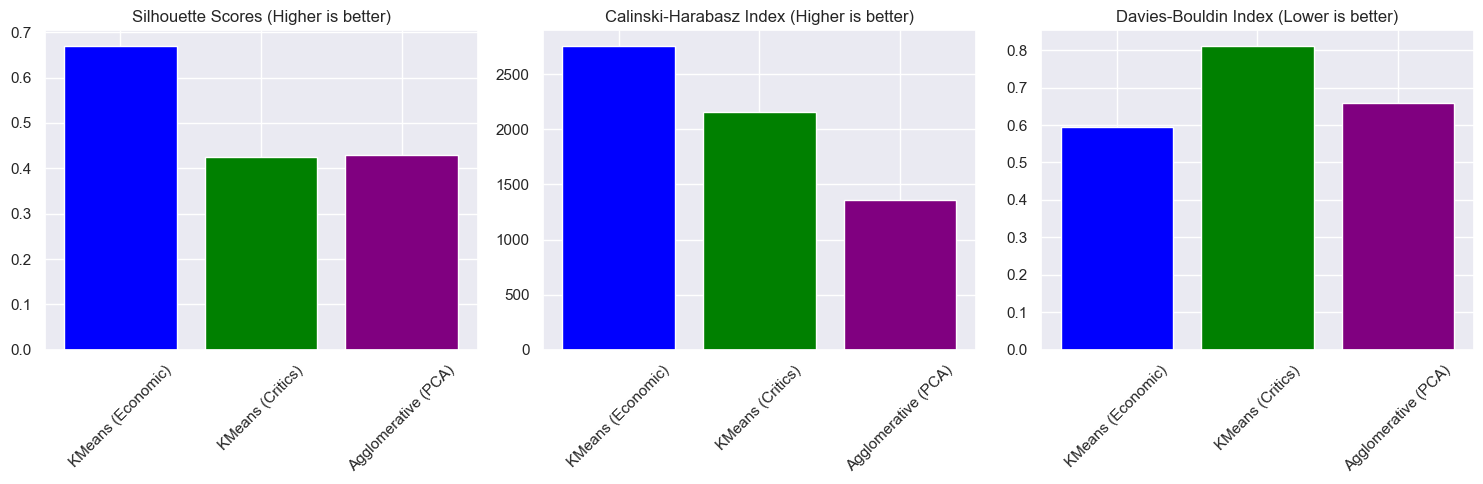

In [232]:
# Data preparation
methods = [
    'KMeans (Economic)', 
    'KMeans (Critics)', 
    'Agglomerative (PCA)'
]
silhouette_scores = [0.6703, 0.4246, 0.4298]
calinski_scores = [2759.784, 2159.789, 1356.566]
davies_scores = [0.5947, 0.8119, 0.6586]
colors = ['blue', 'green', 'purple']

plt.figure(figsize=(15, 5))

# Silhouette Score plot
plt.subplot(1, 3, 1)
for i, method in enumerate(methods):
    plt.bar(method, silhouette_scores[i], color=colors[i])
plt.title('Silhouette Scores (Higher is better)')
plt.xticks(rotation=45)

# Calinski-Harabasz plot
plt.subplot(1, 3, 2)
for i, method in enumerate(methods):
    plt.bar(method, calinski_scores[i], color=colors[i])
plt.title('Calinski-Harabasz Index (Higher is better)')
plt.xticks(rotation=45)

# Davies-Bouldin plot
plt.subplot(1, 3, 3)
for i, method in enumerate(methods):
    plt.bar(method, davies_scores[i], color=colors[i])
plt.title('Davies-Bouldin Index (Lower is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 5. Μοντέλα προβλέψεων

## 5.1 Δημιουργία συνόλων δεδομένων upsamling, downsampling SMOTE

In [ ]:
df = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

train_datasets, test_dataset = build_resampled_datasets(df, test_ratio=0.2)

In [ ]:
train_datasets.keys()

dict_keys(['default', 'upsampled', 'downsampled', 'SMOTE'])

## 5.2 Εκπαίδευση μοντέλων με grid search cross validation

In [ ]:
results = {}

### 5.2.1 ADA Boost

In [ ]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):    

    parameters = {
            'n_estimators': range(10, 201, 10),
    }

    model = AdaBoostClassifier(random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['ADA'][sampling] = {
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                # 'X_train' : X_train,
                # 'y_train' : y_train,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best parameters for default: {'n_estimators': 10}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for upsampled: {'n_estimators': 170}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for downsampled: {'n_estimators': 30}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for SMOTE: {'n_estimators': 180}


### 5.2.2 Gradient Boost

In [ ]:
# Gradient boosting classifier
results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):  

    parameters = {
         "learning_rate": [x/100 for x in range(10,101,20)], 
         "max_depth": [3,5,7], 
         "n_estimators": range(10, 201, 20),
    }

    model = GradientBoostingClassifier(random_state=1) 

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['GRB'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for default: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for upsampled: {'learning_rate': 0.9, 'max_depth': 5, 'n_estimators': 70}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for downsampled: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 130}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for SMOTE: {'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 130}


### 5.2.3 Decision Tree

In [ ]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()): 

    parameters = {   
        'min_samples_split' : range(2, 51, 2),
        'min_samples_leaf' : range(1, 51, 2),
    }

    model = DecisionTreeClassifier(random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    results['DT'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for default: {'min_samples_leaf': 3, 'min_samples_split': 14}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for upsampled: {'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for downsampled: {'min_samples_leaf': 35, 'min_samples_split': 2}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for SMOTE: {'min_samples_leaf': 1, 'min_samples_split': 4}


### 5.2.4 Random Forest

In [ ]:
# Random forest
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):   

    parameters = {
        # 'min_samples_leaf': range(1, 51, 2),
        # 'min_samples_split': range(2, 51, 2),
        'n_estimators': range(10, 201, 20)
    }

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['RF'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for default: {'n_estimators': 190}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for upsampled: {'n_estimators': 130}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for downsampled: {'n_estimators': 30}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for SMOTE: {'n_estimators': 90}


### 5.2.5 K-Nearest Neighbors

In [ ]:
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):   

    parameters = {
        "n_neighbors": range(2,20,2),
        'leaf_size' : range(10, 201, 10)
    }

    model = KNeighborsClassifier(n_jobs=-1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['KNN'][sampling]= {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

    

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for default: {'leaf_size': 10, 'n_neighbors': 4}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for upsampled: {'leaf_size': 10, 'n_neighbors': 2}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for downsampled: {'leaf_size': 10, 'n_neighbors': 10}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for SMOTE: {'leaf_size': 10, 'n_neighbors': 2}


## 5.3 Μετρικές εκπαίδευσης

### 5.3.1 Αναφορά κατηγοριοποίησης στο σύνολο δοκιμής

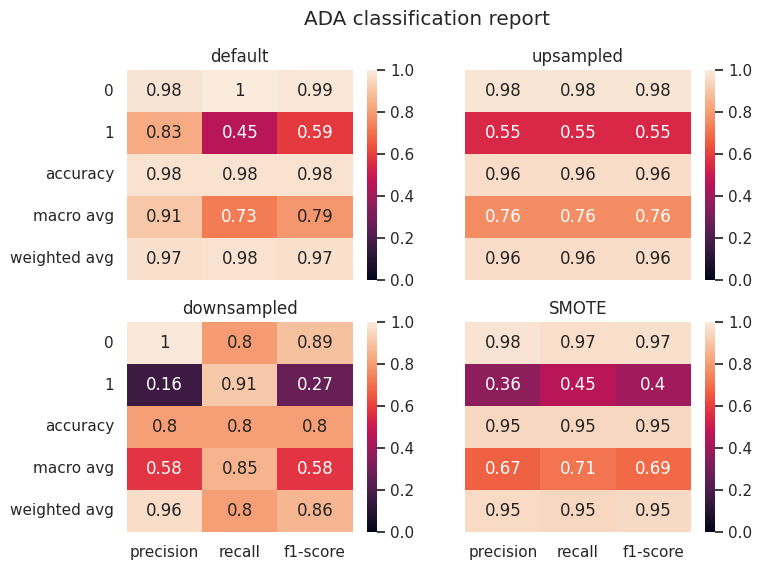

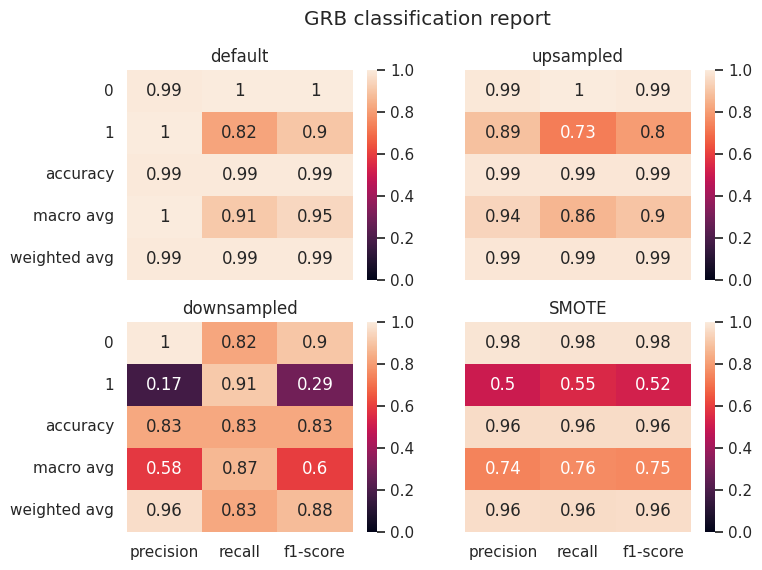

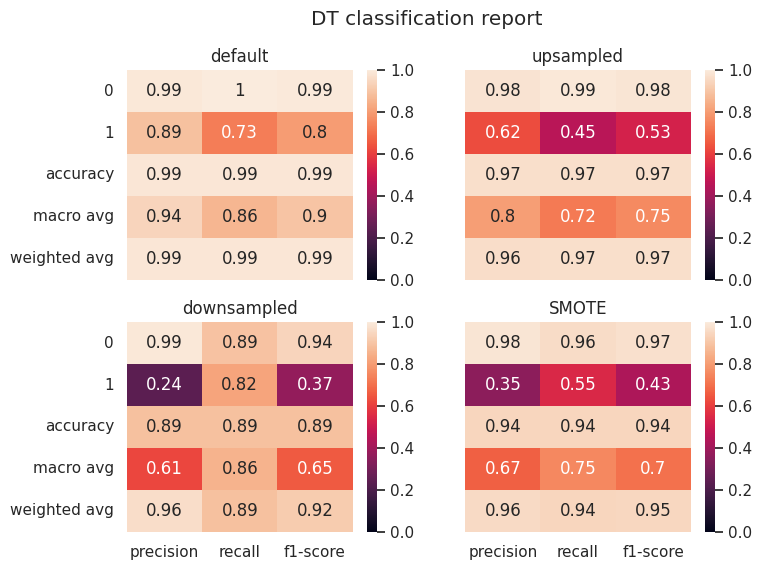

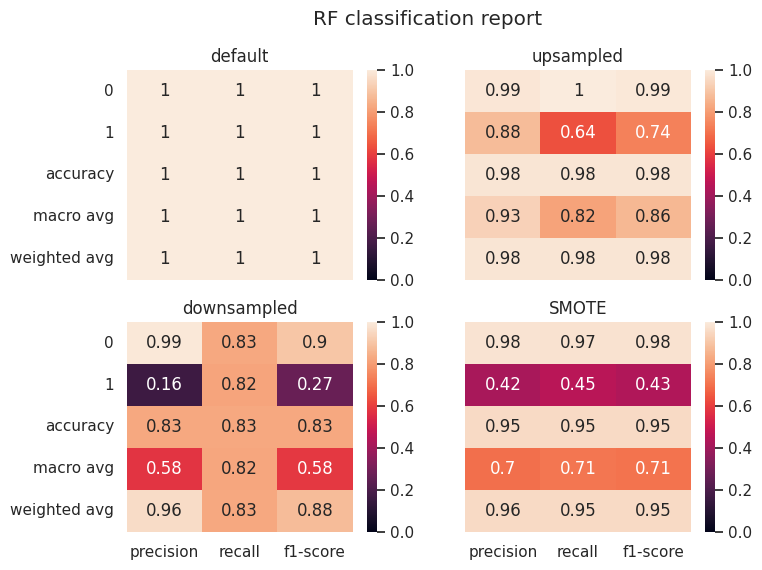

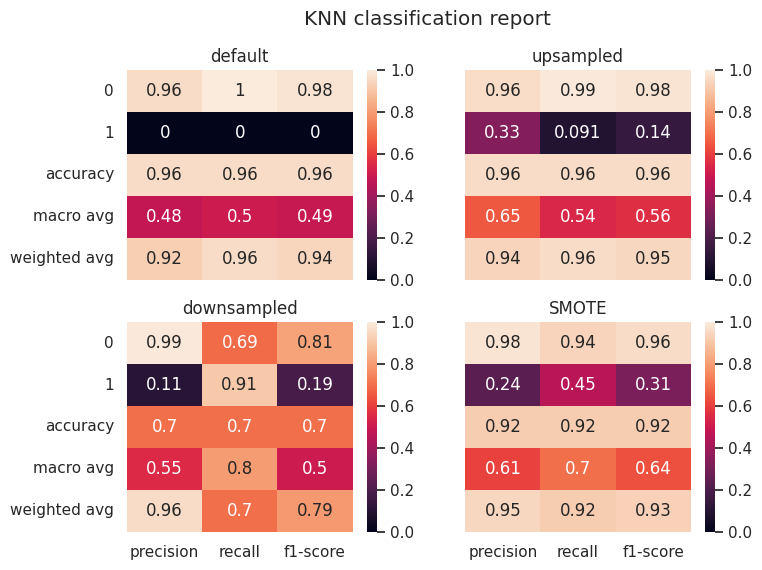

In [ ]:
plot_classification_report(results, 'ADA')
plot_classification_report(results, 'GRB')
plot_classification_report(results, 'DT')
plot_classification_report(results, 'RF')
plot_classification_report(results, 'KNN')

### 5.3.2 Καμπύλες ROC

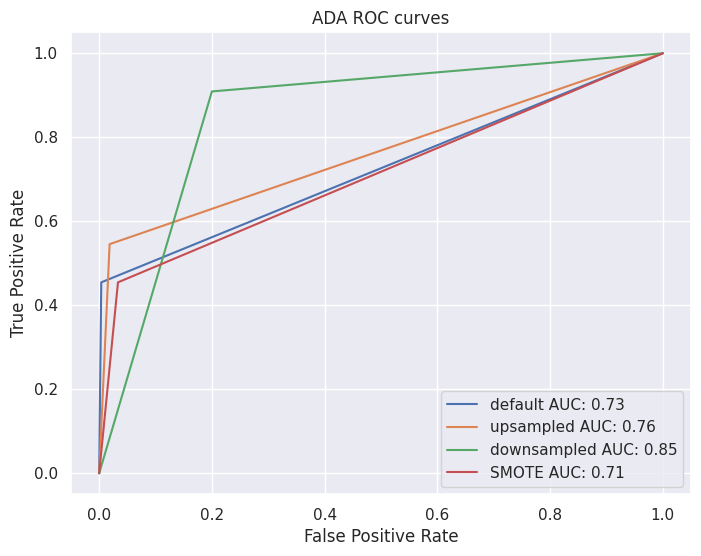

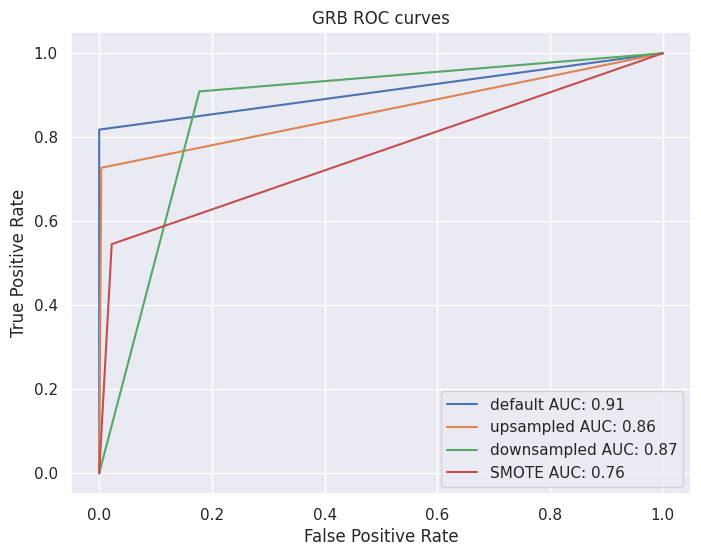

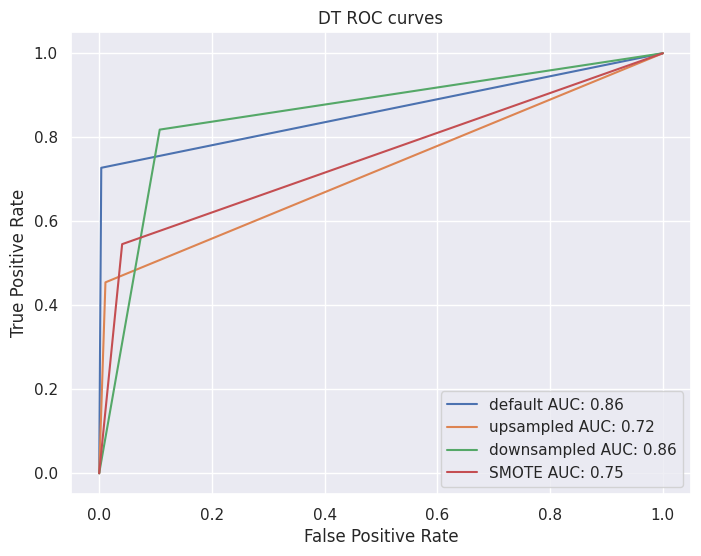

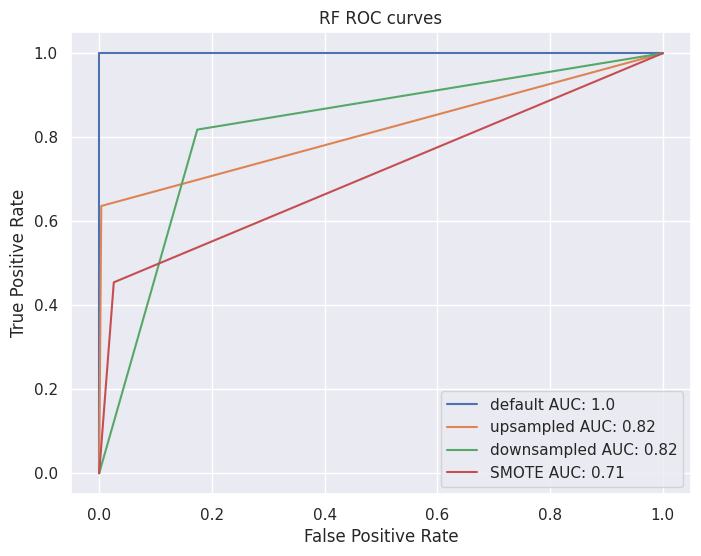

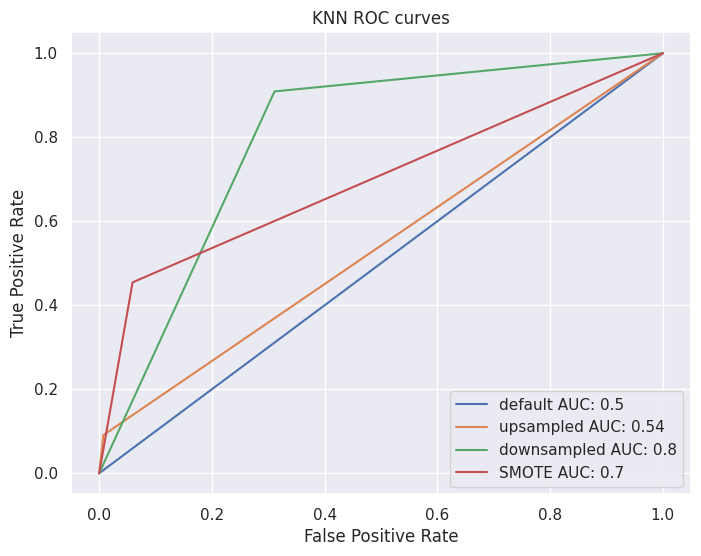

In [ ]:
plot_roc_curves(results, 'ADA')
plot_roc_curves(results, 'GRB')
plot_roc_curves(results, 'DT')
plot_roc_curves(results, 'RF')
plot_roc_curves(results, 'KNN')

### 5.3.3 Πίνακες σύγχησης

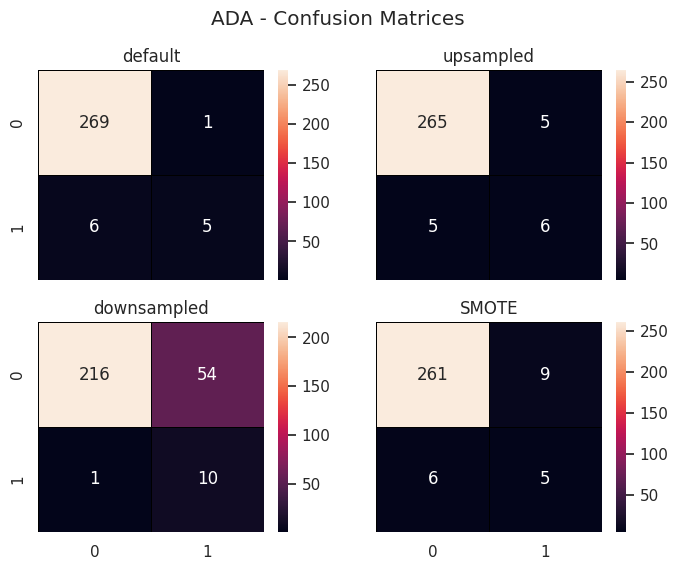

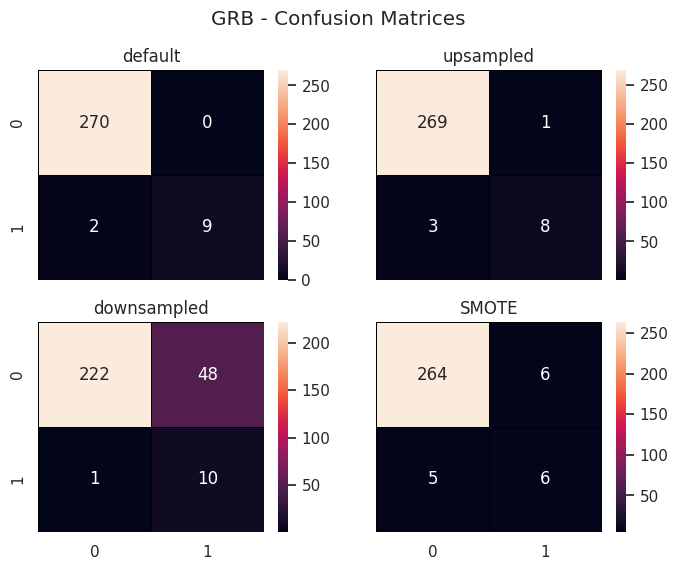

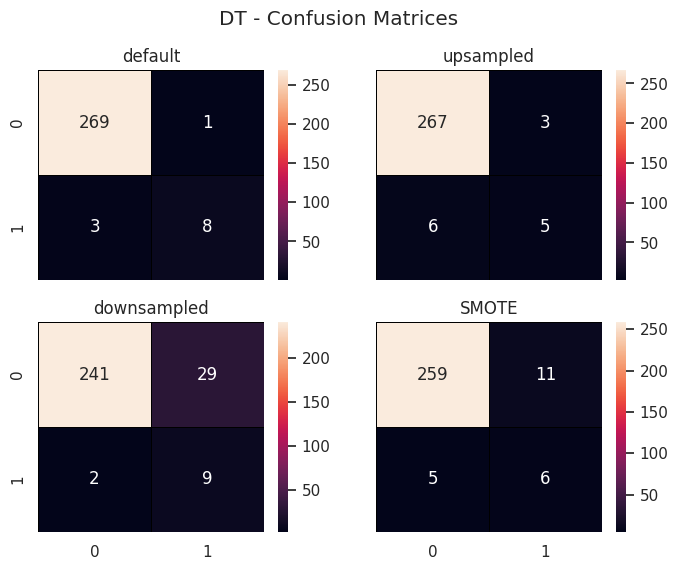

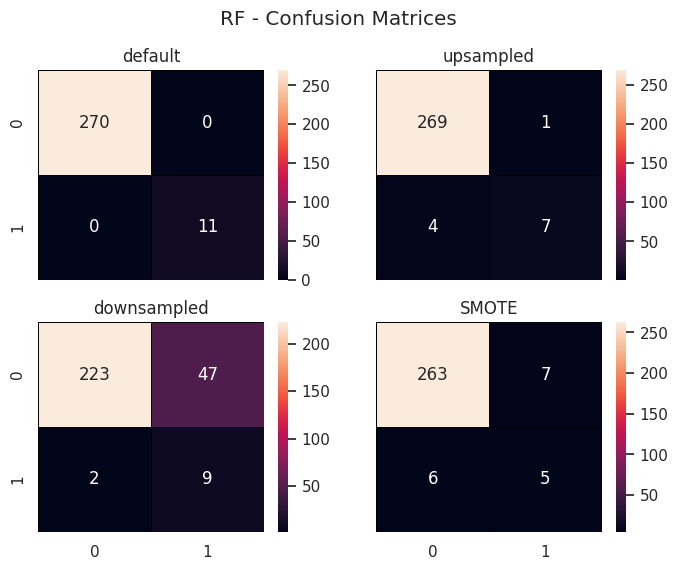

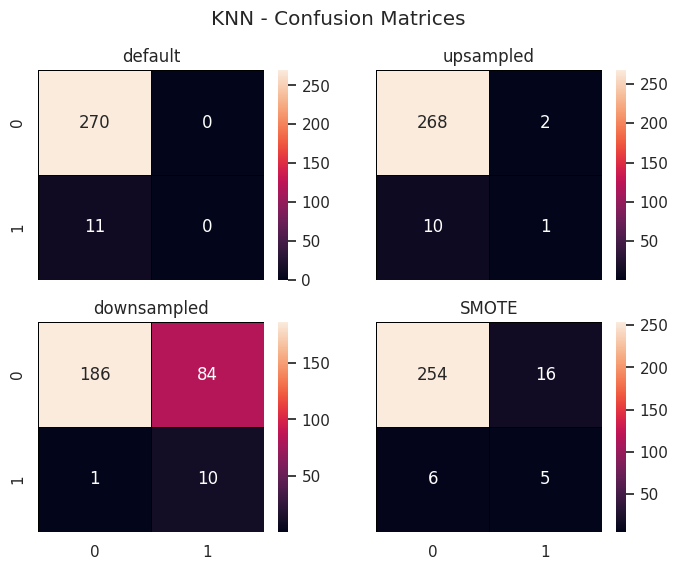

In [ ]:
plot_confusion_matrices(results, 'ADA')
plot_confusion_matrices(results, 'GRB')
plot_confusion_matrices(results, 'DT')
plot_confusion_matrices(results, 'RF')
plot_confusion_matrices(results, 'KNN')

# 6. Προβλέψεις στο άγνωστο σύνολο δεδομένων

## 6.1 Φόρτωση του άγνωστου συνόλου δεδομένων

In [ ]:
X = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)

## 6.2 Φόρτωση παραμέτρων και κατηγοριοποίηση μοντέλων

### 6.2.1 ADA Boost

In [ ]:
# best, sampling = best_f1_score(results, 'ADA')

In [ ]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'ADA')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'n_estimators': 10}

In [ ]:
model = AdaBoostClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

56

### 6.2.2 Gradient Boost

In [ ]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'GRB')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}

In [ ]:
model = GradientBoostingClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

16

### 6.2.3 Decision Tree

In [ ]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'DT')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'min_samples_leaf': 3, 'min_samples_split': 14}

In [ ]:
model = DecisionTreeClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

11

### 6.2.4 Random Forest

In [ ]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'RF')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'n_estimators': 190}

In [ ]:
model = RandomForestClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

4

### 6.2.5 K-Nearest Neighbors

In [ ]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'KNN')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'leaf_size': 10, 'n_neighbors': 2}

In [ ]:
model = KNeighborsClassifier(**best['params'])
model.fit(X_train, y_train)

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

37

## 6.3 Αποτελέσματα προβλέψεων

### 6.3.1 Αριθμός προβλέψεων oscar ανα μοντέλο

In [ ]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,56,16,11,4,37


### 6.3.2 Λεπτομέρειες προβλέψεων μοντέλων

In [ ]:
df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ID','ADA', 'GRB', 'DT','RF', 'KNN']]

,ID,ADA,GRB,DT,RF,KNN
12,13,1,0,0,0,0
20,21,0,0,0,0,1
26,27,0,0,0,0,1
39,40,1,0,0,0,0
44,45,1,0,1,1,0
...,...,...,...,...,...,...
528,529,1,0,0,0,0
547,548,1,0,0,0,0
551,552,0,0,0,0,1
556,557,0,0,0,0,1


### 6.3.3 Επιλογή τελικής απόφασης

In [ ]:
# Majority vote
DECISION_THRESHOLD = 2
predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)
print(f"Final oscars prediction number: {len(predictions[predictions['OSCAR'] == 1])}")

Final oscars prediction number: 17


/tmp/ipykernel_327607/311422637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


In [ ]:
predictions[predictions['OSCAR'] == 1]

,ID,ADA,GRB,DT,RF,KNN,OSCAR
44,45,1,0,1,1,0,1
51,52,1,1,1,0,0,1
79,80,1,0,1,0,1,1
93,94,1,0,0,0,1,1
97,98,1,0,0,0,1,1
132,133,1,1,1,1,0,1
146,147,1,1,1,0,0,1
148,149,0,1,1,1,0,1
215,216,0,1,0,0,1,1
218,219,1,0,0,0,1,1


### 6.3.4 Σύγκριση λόγου oscar / μη oscar στο αρχικό σύνολο και στο άγνωστο

In [ ]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 3.01% | Testing dataset oscar prediction ratio: 3.99%


### 6.3.5 Αποθήκευση αποτελεσμάτων σε αρχείο

In [ ]:
# Save file
# predictions = predictions.drop(['DT','ADA', 'GRB', 'RF', 'KNN'], axis=1)
# predictions.to_csv('./predictions_new.csv', index=False)